### Student details
Student name; **Siddharth Prince**  
Student id: **23052058**

# Goals
The aim of this notebook is to compare the effectiveness of GP and GE and the problem chosen for this comparison is the 4bit-parity problem.

### Houskeeping

In [1]:
!pip install deap

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_39222/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Importing all required packages and tools

In [3]:
import operator
import math
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx

# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

Setting the random seed

In [4]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GP Applied to the 4bit-Parity Problem

GP parameters that will remain constant for all the different setups

In [5]:
# CONSTANT constants:
POPULATION_SIZE = 2000
HALL_OF_FAME_SIZE = 10

GP sepcific constants

In [6]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

The problem constants specific to the 4bit-parity problem

In [7]:
NUM_INPUTS = 4
NUM_COMBINATIONS = 2 ** NUM_INPUTS

In [8]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)
    
# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = getToolbox().compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Adding the function set

In [9]:
# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(operator.xor, 2)
primitiveSet.addPrimitive(operator.not_, 1)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

Creating the toolbox

In [10]:
def getToolbox():
    toolbox = base.Toolbox()
    
    # define a single objective, minimizing fitness strategy:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    
    # create the Individual class based on the primitive tree:
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
    
    # create a helper function for creating random trees using the primitive set:
    toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
    
    # create the individual operator to fill up an Individual instance:
    toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)
    
    # create the population operator to generate a list of individuals:
    toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
    
    # create an operator to compile the primitive tree into python code:
    toolbox.register("compile", gp.compile, pset=primitiveSet)
    
    toolbox.register("evaluate", getCost)
    
    # genetic operators:
    toolbox.register("select", tools.selTournament, tournsize=2)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)
    
    # bloat control:
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

    return toolbox

Setting up our stats to track the progress

Setting up the population

In [11]:
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   

In [12]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

### Setup 1
Mutation => 0.02  
Crossover => 0.7  

Setting the Genetic Programming parameters

In [13]:
# Genetic Programming constants:
P_CROSSOVER = 0.7
P_MUTATION = 0.02
MAX_GENERATIONS = 200

Running the GP for setup #1

In [14]:
toolbox1 = getToolbox()
population1 = population = toolbox1.populationCreator(n=POPULATION_SIZE)
population, logbook = algorithms.eaSimple(population1,
                                                  toolbox1,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	2000  	8.0015	0  	16 	0  	2000  	0.773626	22.409	0  	61 	4  	2000  	13.2246
1  	1401  	7.8715	1  	12 	4  	1401  	0.708511	22.0555	1  	64 	1  	1401  	13.3907
2  	1480  	7.816 	2  	14 	2  	1480  	0.82713 	22.5565	2  	69 	1  	1480  	14.1787
3  	1402  	7.709 	3  	12 	3  	1402  	0.918324	23.4775	3  	71 	1  	1402  	14.9274
4  	1434  	7.5425	4  	12 	0  	1434  	1.14026 	25.2945	4  	87 	1  	1434  	15.311 
5  	1444  	7.4265	5  	13 	0  	1444  	1.23434 	27.634 	5  	84 	1  	1444  	16.2211
6  	1366  	7.1905	6  	12 	0  	1366  	1.34581 	31.0675	6  	84 	1  	1366  	16.8054
7  	1404  	6.9895	7  	12 	0  	1404  	1.43958 	33.8095	7  	107	1  	1404  	16.7088
8  	1429  	6.8105	8  	14 	0  	1429  	1.58069 	36.1725	8  

Plotting the stats as a readable chart.

-- Best Individual =  and_(xor(xor(xor(in_3, in_2), and_(1, in_1)), not_(not_(in_0))), or_(xor(xor(1, in_1), and_(in_0, in_1)), or_(not_(or_(1, and_(0, in_1))), xor(and_(in_3, 0), in_1))))
-- length=32, height=6
-- Best Fitness =  0.0


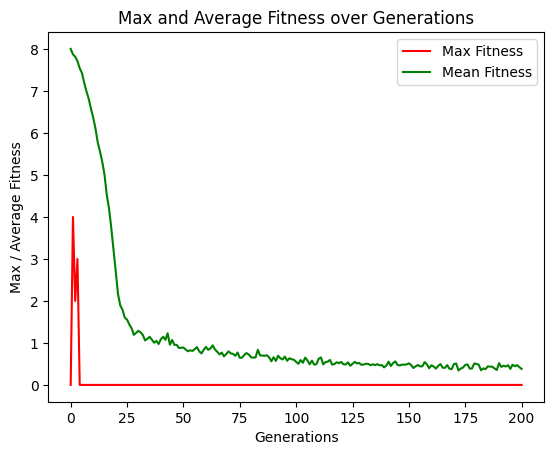

In [15]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generations')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.legend(['Max Fitness', 'Mean Fitness'], loc = 'upper right')
plt.show()

### Setup 2
Mutation => 0.01  
Crossover => 0.9  

Setting the Genetic Programming parameters

In [16]:
# Genetic Programming constants:
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200

Running the GP for setup #2

In [17]:
toolbox2 = getToolbox()
population2 = population = toolbox2.populationCreator(n=POPULATION_SIZE)
population, logbook = algorithms.eaSimple(population2,
                                                  toolbox2,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std    	avg   	gen	max	min	nevals	std    
0  	2000  	8.026	0  	16 	2  	2000  	0.78315	22.683	0  	62 	4  	2000  	13.1724
1  	1811  	7.8945	1  	16 	0  	1811  	0.756551	21.8925	1  	68 	1  	1811  	13.1801
2  	1761  	7.8515	2  	12 	4  	1761  	0.749965	22.607 	2  	82 	1  	1761  	14.1525
3  	1833  	7.8035	3  	12 	0  	1833  	0.839576	23.7625	3  	80 	1  	1833  	15.1648
4  	1810  	7.7185	4  	16 	1  	1810  	0.921552	25.7825	4  	95 	1  	1810  	16.1276
5  	1808  	7.6555	5  	12 	1  	1808  	0.970474	27.908 	5  	91 	1  	1808  	16.7006
6  	1827  	7.555 	6  	12 	1  	1827  	1.02371 	30.2525	6  	109	1  	1827  	17.8618
7  	1819  	7.4785	7  	14 	1  	1819  	1.11469 	32.7245	7  	112	1  	1819  	19.1149
8  	1813  	7.3835	8  	13 	0  	1813  	1.25077 	36.1535	8  	112	1

Plotting the stats as a readable chart.

-- Best Individual =  and_(xor(xor(xor(in_3, in_2), and_(1, in_1)), not_(not_(in_0))), or_(xor(xor(1, in_1), and_(in_0, in_1)), or_(not_(or_(1, and_(0, in_1))), xor(and_(in_3, 0), in_1))))
-- length=32, height=6
-- Best Fitness =  0.0


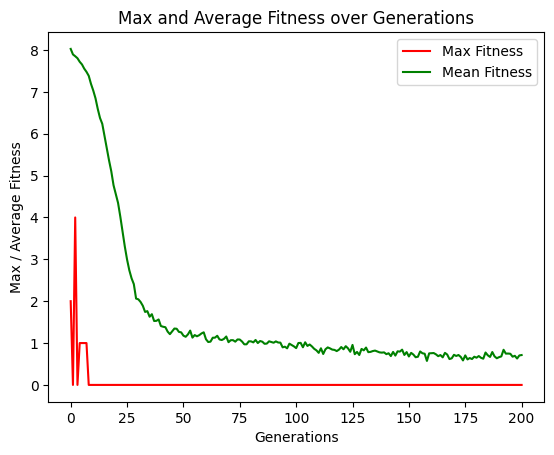

In [18]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generations')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.legend(['Max Fitness', 'Mean Fitness'], loc = 'upper right')
plt.show()

### Setup 3
Mutation => 0.03  
Crossover => 0.8  

Setting the Genetic Programming parameters

In [19]:
# Genetic Programming constants:
P_CROSSOVER = 0.8
P_MUTATION = 0.03
MAX_GENERATIONS = 200

Running the GP for setup #3

In [20]:
toolbox3 = getToolbox()
population3 = population = toolbox3.populationCreator(n=POPULATION_SIZE)
population, logbook = algorithms.eaSimple(population3,
                                                  toolbox3,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	2000  	8.0075	0  	14 	0  	2000  	0.742593	23.091	0  	61 	4  	2000  	13.5075
1  	1606  	7.8925	1  	12 	0  	1606  	0.752292	22.324	1  	69 	1  	1606  	13.5808
2  	1629  	7.8215	2  	12 	0  	1629  	0.74474 	22.73 	2  	69 	1  	1629  	14.2579
3  	1623  	7.762 	3  	12 	0  	1623  	0.819363	23.9965	3  	75 	1  	1623  	14.9023
4  	1590  	7.7045	4  	16 	0  	1590  	0.933906	25.3795	4  	80 	1  	1590  	15.7887
5  	1617  	7.5975	5  	12 	0  	1617  	1.03513 	27.8465	5  	96 	1  	1617  	16.5619
6  	1607  	7.4945	6  	13 	2  	1607  	1.10633 	30.2505	6  	105	1  	1607  	17.5703
7  	1609  	7.3775	7  	16 	2  	1609  	1.21942 	33.815 	7  	119	1  	1609  	18.7529
8  	1595  	7.1945	8  	16 	1  	1595  	1.35228 	36.7715	8  	1

Plotting the stats as a readable chart.

-- Best Individual =  and_(xor(xor(xor(in_3, in_2), and_(1, in_1)), not_(not_(in_0))), or_(xor(xor(1, in_1), and_(in_0, in_1)), or_(not_(or_(1, and_(0, in_1))), xor(and_(in_3, 0), in_1))))
-- length=32, height=6
-- Best Fitness =  0.0


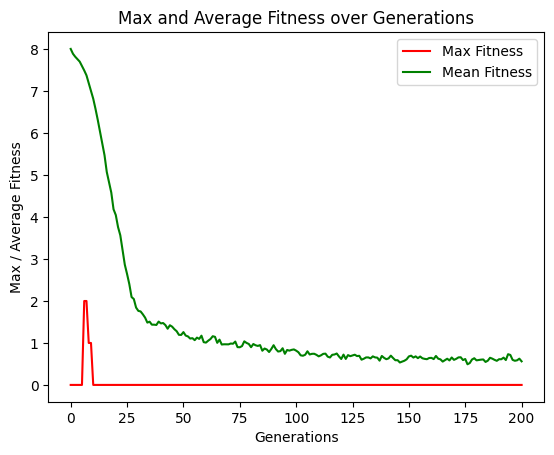

In [21]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generations')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.legend(['Max Fitness', 'Mean Fitness'], loc = 'upper right')
plt.show()

### Observation
A general observation here is that GP seems to be able to stabilise with the best fitness (0) very fast i.e, within a very small amount of generations. In the above 3 cases, within the first 10 generations.

## GE Applied to the 4bit-Parity Problem
We're using the GRAPE library to perform GE on the 4bit-parity problem.  
Code reference: [GRAPE code running parity problems with 3, 4 or 5 bits](https://github.com/conorlime/CS6271/blob/main/GE_Applied_to_Parity_Problems.ipynb)  

In [22]:
from os import path

PATH = './grape/'
if path.exists(PATH):
    print('grape directory already exists')
else:
    # %cd .
    !git clone https://github.com/UL-BDS/grape.git
    print('Cloning grape in your Drive')

%cd ./grape/

grape directory already exists
/home/sprince0031/UL_AI_ML/SEM_1/CS6271-Evolutionary_Computation_and_Humanoid_Robotics/Week06Lab/grape


Imports specific to GE and GRAPE

In [23]:
import grape
import algorithms
from functions import not_, and_, or_, nand_, nor_

import pandas as pd

import textwrap

In [24]:
ELITE_SIZE = 1
HALLOFFAME_SIZE = 1

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 35
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

We only need the dataset for the 4bit-parity problem

In [25]:
X_train = np.zeros([4,16], dtype=bool)
Y_train = np.zeros([16,], dtype=bool)

data = pd.read_table(r"datasets/parity4.csv")
for i in range(4):
    for j in range(16):
        X_train[i,j] = data['d'+ str(i)].iloc[j]
for i in range(16):
    Y_train[i] = data['output'].iloc[i]

GRAMMAR_FILE = 'parity4.bnf'

In [26]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(data)

,d0,d1,d2,d3,output
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,1
4,0,1,0,0,0
5,0,1,0,1,1
6,0,1,1,0,1
7,0,1,1,1,0
8,1,0,0,0,0
9,1,0,0,1,1


Printing the grammar

In [27]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close()

<e>  ::=  <op> | <x>
<op> ::=  and_(<e>,<e>)|
          or_(<e>,<e>)|
          nand_(<e>,<e>)|
          nor_(<e>,<e>)
<x> ::=   x[0]|x[1]|x[2]|x[3]


In [28]:
BNF_GRAMMAR = grape.Grammar(path.join("grammars", GRAMMAR_FILE))

Defining a fitness function where it defines max fitness as the minimum number of outputs that are wrongly predicted

In [29]:
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    # The expected outputs are in Y
    n_samples = len(Y)
    compare = np.equal(Y,pred) # Compare the outputs with the expected values
    n_correct_outputs = np.sum(compare)

    fitness = n_samples - n_correct_outputs

    return fitness,

Since we will be running multiple setups, we're wrapping the toolboc creation code into a callable function.

In [30]:
def getGrapeToolbox():
    toolbox = base.Toolbox()

    # define a single objective, minimising fitness strategy:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    
    creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)
    
    toolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
    #toolbox.register("populationCreator", grape.random_initialisation, creator.Individual)
    
    toolbox.register("evaluate", fitness_eval)
    
    # Tournament selection:
    toolbox.register("select", tools.selTournament, tournsize=6)
    
    # Single-point crossover:
    toolbox.register("mate", grape.crossover_onepoint)
    
    # Flip-int mutation:
    toolbox.register("mutate", grape.mutation_int_flip_per_codon)

    return toolbox

Preparing the stats object

In [31]:
# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

In [32]:
# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

### Setup 1
Mutation => 0.02  
Crossover => 0.7  

In [33]:
# GE constants
P_CROSSOVER = 0.8
P_MUTATION = 0.03
MAX_GENERATIONS = 200

In [34]:
# create initial population (generation 0):
toolbox1 = getGrapeToolbox()
population1 = toolbox1.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

Perform the Grammatical Evolution flow for setup #1

In [35]:
population, logbook = algorithms.ge_eaSimpleWithElitism(population1, toolbox1, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (6.0,)
gen = 1 , Best fitness = (5.0,) , Number of invalids = 393
gen = 2 , Best fitness = (5.0,) , Number of invalids = 252
gen = 3 , Best fitness = (4.0,) , Number of invalids = 151
gen = 4 , Best fitness = (4.0,) , Number of invalids = 132
gen = 5 , Best fitness = (4.0,) , Number of invalids = 115
gen = 6 , Best fitness = (4.0,) , Number of invalids = 90
gen = 7 , Best fitness = (4.0,) , Number of invalids = 90
gen = 8 , Best fitness = (4.0,) , Number of invalids = 70
gen = 9 , Best fitness = (4.0,) , Number of invalids = 63
gen = 10 , Best fitness = (4.0,) , Number of invalids = 49
gen = 11 , Best fitness = (4.0,) , Number of invalids = 47
gen = 12 , Best fitness = (4.0,) , Number of invalids = 39
gen = 13 , Best fitness = (4.0,) , Number of invalids = 38
gen = 14 , Best fitness = (4.0,) , Number of invalids = 41
gen = 15 , Best fitness = (4.0,) , Number of invalids = 28
gen = 16 , Best fitness = (4.0,) , Number of invalids = 39
gen = 17 , Best fitness = (4

Getting the stats formatted into a readable table

In [36]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,8.025500,0.489745,6.0,11.0,189,100.383000,32,17.230500,8.932000,66.922000,126,0.000000,0.232691
1,1,393,7.925949,0.477358,5.0,10.0,306,132.568139,33,13.631612,10.528314,52.526447,130,0.008879,0.945222
2,2,252,7.888444,0.550248,5.0,11.0,306,162.225973,33,15.386156,12.821510,59.544622,130,0.011794,1.034186
3,3,151,7.857220,0.591222,4.0,10.0,189,180.292050,32,16.584640,14.454840,64.338561,126,0.010208,1.162529
4,4,132,7.806210,0.640299,4.0,10.0,189,193.464668,32,17.420771,15.783726,67.683084,126,0.009157,1.254054
5,5,115,7.803714,0.679902,4.0,10.0,189,205.135279,32,17.850398,16.509814,69.401592,126,0.008889,1.320104
6,6,90,7.765445,0.721734,4.0,10.0,189,218.168063,32,18.224607,16.943455,70.898429,126,0.008850,1.400406
7,7,90,7.748691,0.734837,4.0,10.0,189,237.063874,32,19.002094,17.234555,74.008377,126,0.009036,1.486216
8,8,70,7.702591,0.792218,4.0,10.0,189,249.613472,32,18.845078,17.467358,73.380311,126,0.009474,1.472907
9,9,63,7.627775,0.809924,4.0,10.0,189,260.002581,32,19.395973,17.558596,75.583893,126,0.009002,1.564990


Best individual:

In [37]:
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 or_(and_(nand_(x[3],x[0]),and_(or_(x[0],x[3]),and_(or_(x[1],x[2]),nand_(x[1],x[2
])))),or_(nor_(nand_(x[3],x[0]),and_(or_(x[0],x[3]),and_(or_(x[1],x[2]),nand_(x[
1],x[2])))),and_(and_(and_(x[2],x[2]),and_(nor_(x[0],x[3]),x[1])),nand_(nor_(x[1
],x[0]),nand_(x[3],x[0])))))

Training Fitness:  1.0
Depth:  15
Length of the genome:  1401
Used portion of the genome: 0.07


Plotting the data into a graphs to guage its performance

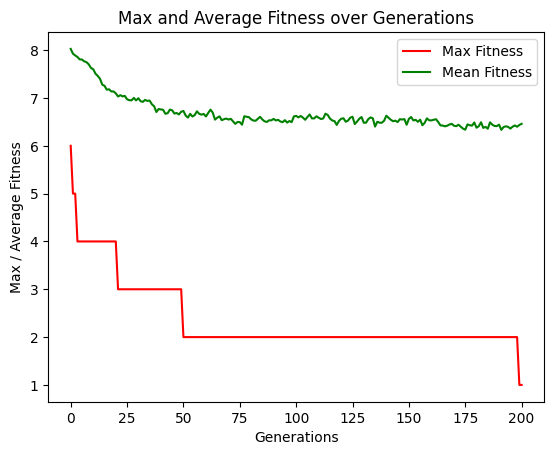

In [38]:
plt.plot(min_fitness_values, color='red')
plt.plot(mean_fitness_values, color='green')
plt.xlabel('Generations')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.legend(['Max Fitness', 'Mean Fitness'], loc = 'upper right')
plt.show()

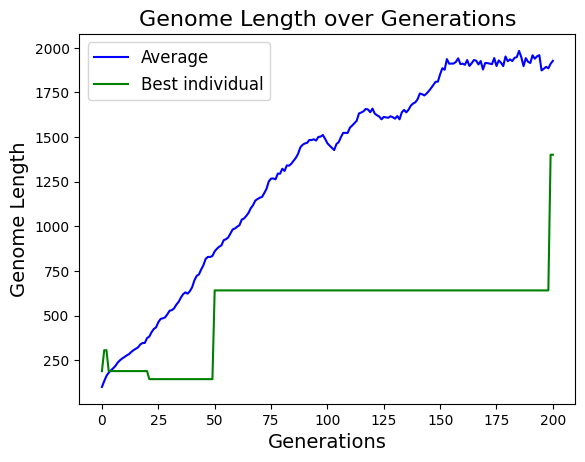

In [39]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()

### Setup 2
Mutation => 0.01  
Crossover => 0.9  

In [40]:
# GE constants
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200

In [41]:
# create initial population (generation 0):
toolbox2 = getGrapeToolbox()
population2 = toolbox2.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

Perform the Grammatical Evolution flow for setup #2

In [42]:
population, logbook = algorithms.ge_eaSimpleWithElitism(population2, toolbox2, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (1.0,)
gen = 1 , Best fitness = (1.0,) , Number of invalids = 444
gen = 2 , Best fitness = (1.0,) , Number of invalids = 270
gen = 3 , Best fitness = (1.0,) , Number of invalids = 170
gen = 4 , Best fitness = (1.0,) , Number of invalids = 131
gen = 5 , Best fitness = (1.0,) , Number of invalids = 115
gen = 6 , Best fitness = (1.0,) , Number of invalids = 98
gen = 7 , Best fitness = (1.0,) , Number of invalids = 58
gen = 8 , Best fitness = (1.0,) , Number of invalids = 40
gen = 9 , Best fitness = (1.0,) , Number of invalids = 35
gen = 10 , Best fitness = (1.0,) , Number of invalids = 26
gen = 11 , Best fitness = (0.0,) , Number of invalids = 28
gen = 12 , Best fitness = (0.0,) , Number of invalids = 17
gen = 13 , Best fitness = (0.0,) , Number of invalids = 21
gen = 14 , Best fitness = (0.0,) , Number of invalids = 15
gen = 15 , Best fitness = (0.0,) , Number of invalids = 12
gen = 16 , Best fitness = (0.0,) , Number of invalids = 13
gen = 17 , Best fitness = (0

Getting the stats formatted into a readable table

In [43]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,8.015500,0.497252,5.0,11.0,1401,100.170000,25,17.195000,8.888000,66.780000,98,0.000000,0.198182
1,1,444,7.878535,0.549622,1.0,10.0,1401,135.582262,25,15.003213,10.588689,58.012853,98,0.008905,0.931597
2,2,270,7.797688,0.664192,1.0,11.0,1401,175.155491,25,18.279769,13.284393,71.119075,98,0.009145,1.115810
3,3,170,7.670492,0.790762,1.0,11.0,1401,203.050273,25,21.901639,15.926776,85.606557,98,0.008893,1.464132
4,4,131,7.573569,0.924992,1.0,11.0,1401,239.635634,25,24.384698,17.397004,95.538791,98,0.009138,1.599640
5,5,115,7.445623,1.168026,1.0,14.0,1401,278.953316,25,26.648276,18.195756,104.593103,98,0.009091,1.825198
6,6,98,7.179811,1.451368,1.0,13.0,1401,328.996320,25,27.462145,18.658254,107.848580,98,0.012744,2.015812
7,7,58,6.752317,1.772874,1.0,13.0,1401,384.912976,25,28.489701,19.186406,111.958805,98,0.008942,2.136514
8,8,40,6.232653,2.080020,1.0,12.0,1401,432.181633,25,29.594388,19.819388,116.377551,98,0.009039,2.489846
9,9,35,5.609160,2.324538,1.0,14.0,1401,472.929771,25,31.761832,20.587786,125.047328,98,0.009618,3.081618


Best individual:

In [44]:
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 or_(and_(nand_(x[3],x[0]),and_(or_(x[0],x[3]),and_(or_(x[1],x[2]),nand_(x[1],x[2
])))),or_(nor_(or_(x[3],x[0]),and_(or_(x[1],x[2]),nand_(x[1],x[2]))),or_(nor_(na
nd_(x[3],x[0]),and_(or_(x[0],x[3]),and_(or_(x[1],x[2]),nand_(x[1],x[2])))),and_(
and_(and_(x[2],x[2]),and_(nor_(x[0],x[3]),x[1])),nand_(nor_(or_(nand_(x[1],or_(x
[0],x[3])),x[3]),x[0]),and_(or_(x[0],x[3]),and_(or_(x[1],x[2]),nand_(x[1],x[2]))
))))))

Training Fitness:  0.0
Depth:  21
Length of the genome:  1489
Used portion of the genome: 0.10


Plotting the data into a graphs to guage its performance

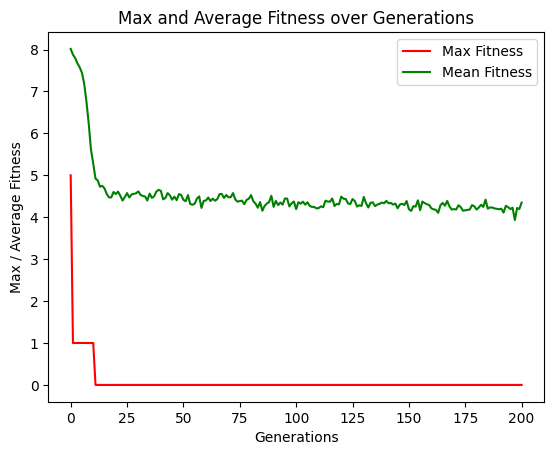

In [45]:
plt.plot(min_fitness_values, color='red')
plt.plot(mean_fitness_values, color='green')
plt.xlabel('Generations')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.legend(['Max Fitness', 'Mean Fitness'], loc = 'upper right')
plt.show()

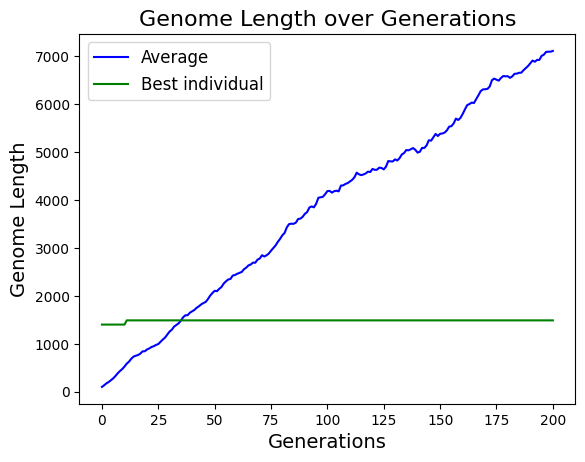

In [46]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()

### Setup 3
Mutation => 0.03  
Crossover => 0.8  

In [47]:
# GE constants
P_CROSSOVER = 0.8
P_MUTATION = 0.03
MAX_GENERATIONS = 200

In [48]:
# create initial population (generation 0):
toolbox3 = getGrapeToolbox()
population3 = toolbox3.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

Perform the Grammatical Evolution flow for setup #3

In [49]:
population, logbook = algorithms.ge_eaSimpleWithElitism(population3, toolbox3, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (0.0,)
gen = 1 , Best fitness = (0.0,) , Number of invalids = 383
gen = 2 , Best fitness = (0.0,) , Number of invalids = 235
gen = 3 , Best fitness = (0.0,) , Number of invalids = 144
gen = 4 , Best fitness = (0.0,) , Number of invalids = 150
gen = 5 , Best fitness = (0.0,) , Number of invalids = 114
gen = 6 , Best fitness = (0.0,) , Number of invalids = 92
gen = 7 , Best fitness = (0.0,) , Number of invalids = 63
gen = 8 , Best fitness = (0.0,) , Number of invalids = 61
gen = 9 , Best fitness = (0.0,) , Number of invalids = 59
gen = 10 , Best fitness = (0.0,) , Number of invalids = 41
gen = 11 , Best fitness = (0.0,) , Number of invalids = 19
gen = 12 , Best fitness = (0.0,) , Number of invalids = 12
gen = 13 , Best fitness = (0.0,) , Number of invalids = 12
gen = 14 , Best fitness = (0.0,) , Number of invalids = 16
gen = 15 , Best fitness = (0.0,) , Number of invalids = 21
gen = 16 , Best fitness = (0.0,) , Number of invalids = 17
gen = 17 , Best fitness = (0

Getting the stats formatted into a readable table

In [50]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,8.000000,0.500000,6.0,11.0,1489,100.365000,38,17.227500,8.899000,66.910000,150,0.000000,0.187616
1,1,383,7.922078,0.519372,0.0,10.0,1489,138.386518,38,14.844156,10.956710,57.376623,150,0.008791,0.884695
2,2,235,7.901983,0.603128,0.0,10.0,1489,170.870255,38,16.547875,13.313881,64.191501,150,0.008953,1.230005
3,3,144,7.834591,0.672833,0.0,10.0,1489,192.176724,38,17.540948,14.815733,68.163793,150,0.009302,1.268479
4,4,150,7.821622,0.738565,0.0,10.0,1489,216.247027,38,19.370270,16.273514,75.481081,150,0.008755,1.301138
5,5,114,7.777306,0.842429,0.0,10.0,1489,251.752386,38,18.718982,16.507953,72.875928,150,0.008898,1.358832
6,6,92,7.736373,0.930047,0.0,11.0,1489,282.917715,38,18.887317,16.875262,73.549266,150,0.009002,1.574313
7,7,63,7.668560,0.912602,0.0,10.0,1489,292.113061,38,18.865772,17.161074,73.463087,150,0.009314,1.482841
8,8,61,7.610624,1.050313,0.0,12.0,1489,311.721506,38,19.191336,17.405364,74.765343,150,0.009553,1.541643
9,9,59,7.492530,1.101529,0.0,11.0,1489,347.163318,38,19.481195,17.679031,75.924781,150,0.009261,1.540171


Best individual:

In [51]:
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 or_(and_(nand_(x[3],x[0]),and_(or_(x[0],x[3]),and_(or_(x[1],x[2]),nand_(x[1],x[2
])))),or_(nor_(or_(x[3],x[0]),and_(or_(x[1],x[2]),nand_(x[1],x[2]))),or_(nor_(na
nd_(x[3],x[0]),and_(or_(x[0],x[3]),and_(or_(x[1],x[2]),nand_(x[1],x[2])))),and_(
and_(and_(x[2],x[2]),and_(nor_(x[0],x[3]),x[1])),nand_(nor_(or_(nand_(x[1],or_(x
[0],x[3])),x[3]),x[0]),and_(or_(x[0],x[3]),and_(or_(x[1],x[2]),nand_(x[1],x[2]))
))))))

Training Fitness:  0.0
Depth:  21
Length of the genome:  1489
Used portion of the genome: 0.10


Plotting the data into a graphs to guage its performance

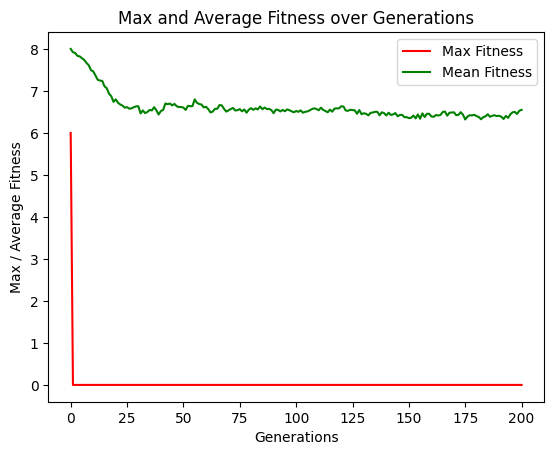

In [52]:
plt.plot(min_fitness_values, color='red')
plt.plot(mean_fitness_values, color='green')
plt.xlabel('Generations')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.legend(['Max Fitness', 'Mean Fitness'], loc = 'upper right')
plt.show()

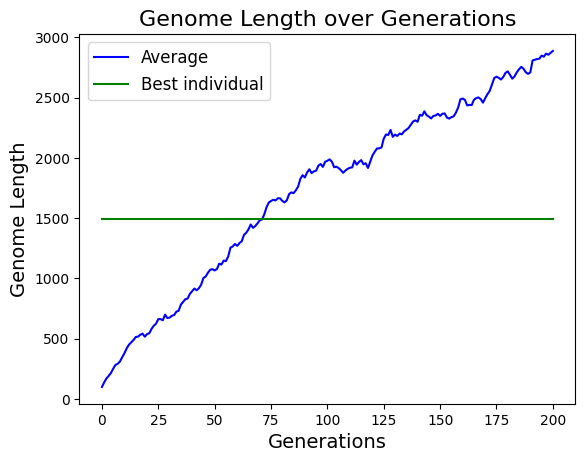

In [53]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()

### Observation
GE has taken a lot more generations to get to the best possible fitness. For setup 1, it barely got to the min fitness value of 1 in the 199th generation. In the subsequent GE setups, it seems to have kept running over the same trained model which it shouldn't and I acknowledge that. But for what output is available, my inference is that GP is generally more efficient at arriving at solutions to lesser complex and well defined problems while GE goes through a large search space which would be more apt for problems that are not well definied and do not have a well documented best solution yet.